# LSTM 4 (튜닝ver)
### * lag, ma, 변동률(pct) 중심 시계열 특화 피처만
### * Bidirectional LSTM
### *Dropout 0.3 → 0.2


In [ ]:
!pip install tensorflow scikit-learn pandas numpy matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/all_features.csv', index_col=0, parse_dates=True)

In [ ]:
# 쉼표 제거 및 숫자형 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 결측치 제거
df = df.dropna()

In [ ]:
target_col = '원/미국달러(매매기준율)'

# 타깃 기준 파생
df['환율_lag1'] = df[target_col].shift(1)
df['환율_ma3'] = df[target_col].rolling(3).mean()
df['환율_pct'] = df[target_col].pct_change()
df['환율_diff'] = df[target_col].diff()

# 자산 가격 관련
for col in ['금', '은', '원유', 'KOSPI', 'NASDAQ']:
    df[f'{col}_pct'] = df[col].pct_change()
    df[f'{col}_diff'] = df[col].diff()

# 금리 관련
for col in ['국고채(3년)(%)', '국고채(10년)(%)', '기준금리', 'CD(91일)', '무담보콜금리(1일, 전체거래)']:
    df[f'{col}_diff'] = df[col].diff()

# 무역 지표
for col in ['수출물가지수(달러기준)', '수입물가지수(달러기준)']:
    df[f'{col}_pct'] = df[col].pct_change()

# 심리지표
for col in ['뉴스심리지수', '경제심리지수', '미국 소비자심리지수']:
    df[f'{col}_diff'] = df[col].diff()

df = df.dropna()

In [ ]:
# 'lag', 'ma', 'pct', 'diff' 포함된 컬럼만 선택
selected_cols = [col for col in df.columns if any(kw in col.lower() for kw in ['lag', 'ma', 'pct', 'diff'])]
X = df[selected_cols]
y = df[target_col]

In [ ]:
# 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# 시퀀스 (30일 → 60일)
def create_sequences(X, y, seq_len=60):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=60)

In [ ]:
# train/test
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [ ]:
# Bidirectional LSTM 모델
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 0.2334 - val_loss: 0.0220
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 0.0359 - val_loss: 0.0090
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0219 - val_loss: 0.0102
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.0224 - val_loss: 0.0065
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0233 - val_loss: 0.0137
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0550 - val_loss: 0.0110
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.0268 - val_loss: 0.0082
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 0.0163 - val_loss: 0.0072
Epoch 9/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0132 - val_loss: 0.0085


In [ ]:
# 정규화 복원 (역변환)
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("LSTM 4 튜닝1ver 예측 성능")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

LSTM 4 튜닝1ver 예측 성능
MSE: 328.64
MAE: 14.32
RMSE: 18.13
R²: 0.9611


### 실제 예측률

In [ ]:
# ✅ 마지막 60일 기준으로 3월 예측 시작 (LSTM 출력 = 환율 그 자체)
last_60_X = X_scaled[-60:].copy()  # (60, 변수 수)
predicted_rates = []

for _ in range(31):  # 3월 예측: 31일
    # 입력은 항상 최신 60일
    pred = model.predict(last_60_X.reshape(1, 60, -1), verbose=0)

    # 스케일 복원 (환율 자체 예측)
    pred_rate = scaler_y.inverse_transform(pred)[0][0]
    predicted_rates.append(pred_rate)

    # 다음 입력 구성: 마지막 행 복사해서 사용 (예측값으로는 X 못 업데이트하므로 관측된 최신 피처 그대로 유지)
    next_input = last_60_X[-1].copy()  # 구조 유지용
    last_60_X = np.vstack([last_60_X[1:], next_input])  # 단순한 sliding window

# ✅ 변화율 계산 (전일 대비 비율 변화 %)
predicted_returns = [0]  # 첫 날은 변화율 없음
for i in range(1, len(predicted_rates)):
    change = (predicted_rates[i] - predicted_rates[i-1]) / predicted_rates[i-1] * 100
    predicted_returns.append(change)

# ✅ 결과 출력
future_dates = pd.date_range(start="2025-03-01", periods=31)
pred_df = pd.DataFrame({
    "DATE": future_dates,
    "예측_환율": predicted_rates,
    "예측_변화율(%)": predicted_returns
})

print("📊 LSTM 기반 3월 환율 예측 결과 (환율 자체 예측 기준):")
print(pred_df.to_string(index=False))

📊 LSTM 기반 3월 환율 예측 결과 (환율 자체 예측 기준):
      DATE       예측_환율  예측_변화율(%)
2025-03-01 1468.742554   0.000000
2025-03-02 1468.628906  -0.007738
2025-03-03 1463.447144  -0.352830
2025-03-04 1447.425659  -1.094777
2025-03-05 1417.828857  -2.044789
2025-03-06 1407.510498  -0.727758
2025-03-07 1401.081299  -0.456778
2025-03-08 1383.763672  -1.236019
2025-03-09 1374.496582  -0.669702
2025-03-10 1364.424438  -0.732788
2025-03-11 1351.440796  -0.951584
2025-03-12 1346.983276  -0.329835
2025-03-13 1342.379761  -0.341765
2025-03-14 1339.211792  -0.235996
2025-03-15 1338.408936  -0.059950
2025-03-16 1337.148438  -0.094179
2025-03-17 1335.645752  -0.112380
2025-03-18 1338.769043   0.233841
2025-03-19 1333.958618  -0.359317
2025-03-20 1333.043945  -0.068568
2025-03-21 1333.287720   0.018287
2025-03-22 1335.840820   0.191489
2025-03-23 1334.707886  -0.084811
2025-03-24 1335.472534   0.057290
2025-03-25 1335.925049   0.033884
2025-03-26 1336.405884   0.035993
2025-03-27 1335.127930  -0.095626
2025-03-28 

<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-7bacf1c155a6>:11: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

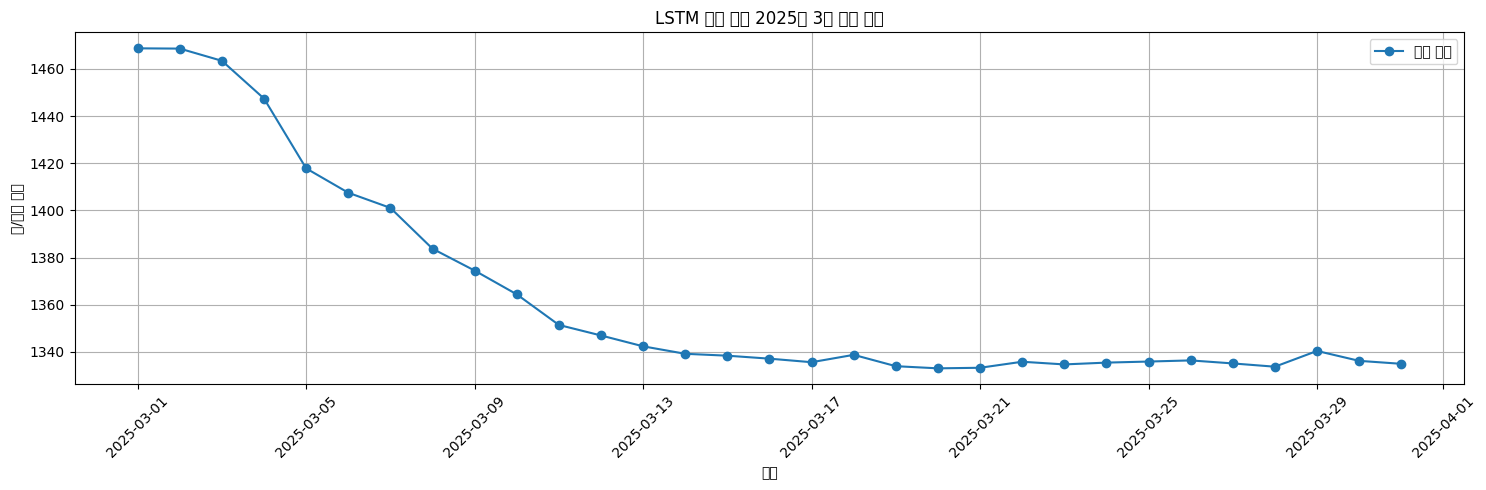

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(pred_df["DATE"], pred_df["예측_환율"], label='예측 환율', marker='o')
plt.title("LSTM 예측 기반 2025년 3월 환율 전망")
plt.xlabel("날짜")
plt.ylabel("원/달러 환율")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# 3월 1일부터 3월 31일까지의 환율 데이터 다운로드
df_real = yf.download('USDKRW=X', start='2025-03-01', end='2025-04-01')

# 'Close' 열을 '실제 환율'로 이름 변경
df_real = df_real[['Close']].rename(columns={'Close': '실제 환율'})

# 인덱스를 'DATE' 열로 변환
df_real.reset_index(inplace=True)
df_real['DATE'] = df_real['Date'].dt.date
df_real.drop(columns=['Date'], inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-16-19db9b7537c4>:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_real.drop(columns=['Date'], inplace=True)


In [ ]:
print(df_real.head())

Price         실제 환율        DATE
Ticker     USDKRW=X            
0       1459.800049  2025-03-03
1       1457.930054  2025-03-04
2       1452.849976  2025-03-05
3       1443.030029  2025-03-06
4       1446.500000  2025-03-07


In [ ]:
pred_df = pred_df.sort_values(by='DATE').reset_index(drop=True)
df_real = df_real.sort_values(by='DATE').reset_index(drop=True)

In [ ]:
# 예측 데이터프레임에 실제 환율 열 붙이기 (순서 기준)
pred_df['실제 환율'] = df_real['실제 환율']

# 오차 계산
pred_df['예측 오차(원)'] = pred_df['예측_환율'] - pred_df['실제 환율']
pred_df['예측 오차율(%)'] = pred_df['예측 오차(원)'] / pred_df['실제 환율'] * 100

In [ ]:
print("📊 예측 vs 실제 비교 결과 (병합 없이 정렬 기반):")
print(pred_df[['DATE', '예측_환율', '실제 환율', '예측 오차(원)', '예측 오차율(%)']].to_string(index=False))

📊 예측 vs 실제 비교 결과 (병합 없이 정렬 기반):
      DATE       예측_환율       실제 환율    예측 오차(원)  예측 오차율(%)
2025-03-01 1468.742554 1459.800049    8.942505   0.612584
2025-03-02 1468.628906 1457.930054   10.698853   0.733839
2025-03-03 1463.447144 1452.849976   10.597168   0.729406
2025-03-04 1447.425659 1443.030029    4.395630   0.304611
2025-03-05 1417.828857 1446.500000  -28.671143  -1.982105
2025-03-06 1407.510498 1446.260010  -38.749512  -2.679291
2025-03-07 1401.081299 1457.030029  -55.948730  -3.839916
2025-03-08 1383.763672 1451.020020  -67.256348  -4.635108
2025-03-09 1374.496582 1448.750000  -74.253418  -5.125344
2025-03-10 1364.424438 1453.229980  -88.805542  -6.110908
2025-03-11 1351.440796 1449.050049  -97.609253  -6.736086
2025-03-12 1346.983276 1442.489990  -95.506714  -6.620962
2025-03-13 1342.379761 1448.939941 -106.560181  -7.354355
2025-03-14 1339.211792 1443.390015 -104.178223  -7.217607
2025-03-15 1338.408936 1465.819946 -127.411011  -8.692132
2025-03-16 1337.148438 1464.780029 -127.

<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-74bae80f24ea>:11: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<

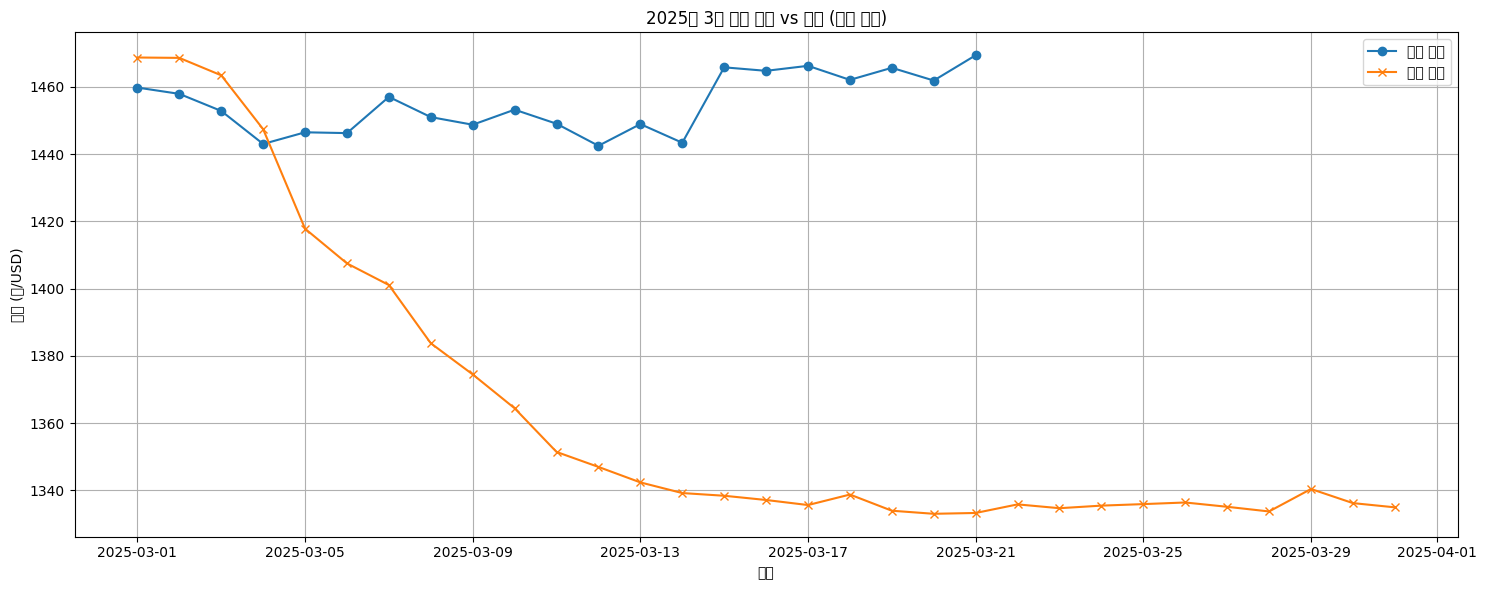

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(pred_df['DATE'], pred_df['실제 환율'], label='실제 환율', marker='o')
plt.plot(pred_df['DATE'], pred_df['예측_환율'], label='예측 환율', marker='x')
plt.title("2025년 3월 환율 예측 vs 실제 (정렬 기반)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### train/test loss

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='훈련 손실 (loss)', color='royalblue')
    plt.plot(history.history['val_loss'], label='검증 손실 (val_loss)', linestyle='--', color='darkorange')
    plt.title("LSTM 학습 손실 변화 (Dropout 0.2)", fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

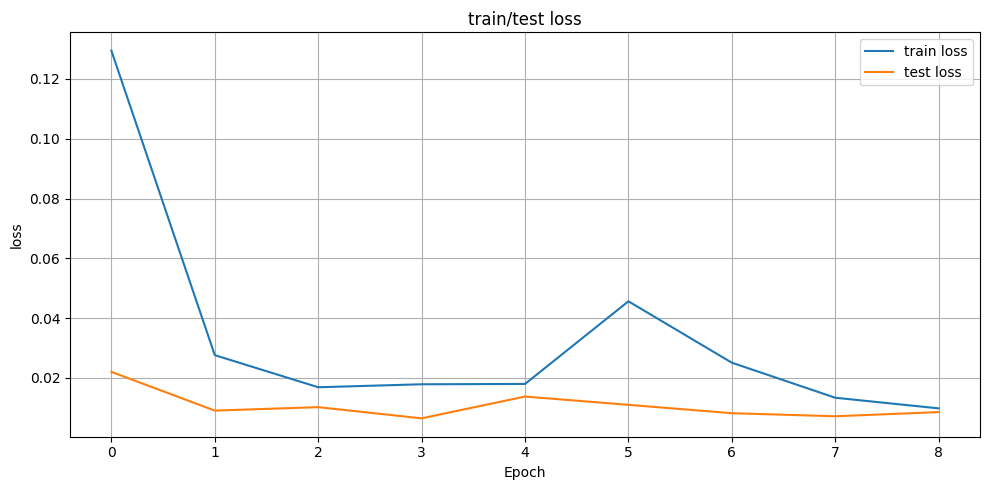

In [ ]:
plot_training_history(history)

In [ ]:
def evaluate_history(history):
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    result = {
        '최종 훈련 손실': train_losses[-1],
        '최종 검증 손실': val_losses[-1],
        '최소 훈련 손실': min(train_losses),
        '최소 검증 손실': min(val_losses),
        '최소 손실 차이': abs(min(train_losses) - min(val_losses)),
        '최소 검증 손실 발생 에포크': val_losses.index(min(val_losses)) + 1
    }

    return pd.DataFrame(result, index=['값'])

In [ ]:
evaluate_history(history)

,최종 훈련 손실,최종 검증 손실,최소 훈련 손실,최소 검증 손실,최소 손실 차이,최소 검증 손실 발생 에포크
값,0.009791,0.008542,0.009791,0.006453,0.003338,4
